In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from pprint import pprint
import re
import json
import gzip
class LTEParser:
    @staticmethod
    def parse(inFile, flowDuration = 100):
        #VIDEO
        videoAverages = []
        videoFairness = []
        videoDelay = []
        videoJitter = []
        videoPLR = []
        #VOICE
        voiceAverages = []
        voiceFairness = []
        voiceDelay = []
        voiceJitter = []
        voicePLR = []
        #INFBUF
        infBufAverages = []
        infBufFairness = []
        infBufDelay = []
        infBufJitter = []
        infBufPLR = []
        #GERAL
        packetLoss = []
        for sfile in inFile:
            content = ""
            print("Opening file: " + sfile)
            with gzip.open(sfile, 'rb') as file:
                content = file.read()
                content = content.decode('utf-8')
            print("Parsing file ...", end="")
            txContent, rxContent = LTEParser._parse(content)
            info = LTEParser.getFairnessIndex(rxContent, flowDuration)
            packetLossInfo = LTEParser.getPacketLossRatio(txContent, rxContent)
            delayInfo = LTEParser.getDelayJitter(rxContent)
            #VIDEO
            videoAverages.append(info['VIDEO']['Average'])
            videoFairness.append(info['VIDEO']['FairnessIndex'])
            videoDelay.append(delayInfo['VIDEO']['Average'])
            videoJitter.append(delayInfo['VIDEO']['StD'])
            videoPLR.append(packetLossInfo[1]['VIDEO'])
            #VOICE
            voiceAverages.append(info['VOIP']['Average'])
            voiceFairness.append(info['VOIP']['FairnessIndex'])
            voiceDelay.append(delayInfo['VOIP']['Average'])
            voiceJitter.append(delayInfo['VOIP']['StD'])
            voicePLR.append(packetLossInfo[1]['VOIP'])
            #INFBUF
            infBufAverages.append(info['INF_BUF']['Average'])
            infBufFairness.append(info['INF_BUF']['FairnessIndex'])
            infBufDelay.append(delayInfo['INF_BUF']['Average'])
            infBufJitter.append(delayInfo['INF_BUF']['StD'])
            infBufPLR.append(packetLossInfo[1]['INF_BUF'])
            #GERAL
            packetLoss.append(packetLossInfo[0])
        return [#VIDEO
                (sum(videoAverages)/len(videoAverages)),
                (sum(videoFairness)/len(videoFairness)),
                (sum(videoDelay)/len(videoDelay)),
                (sum(videoJitter)/len(videoJitter)),
                (sum(videoPLR)/len(videoPLR)),
                #VOICE
                (sum(voiceAverages)/len(voiceAverages)),
                (sum(voiceFairness)/len(voiceFairness)),
                (sum(voiceDelay)/len(voiceDelay)),
                (sum(voiceJitter)/len(voiceJitter)),
                (sum(voicePLR)/len(voicePLR)),
                #INFBUF
                (sum(infBufAverages)/len(infBufAverages)),
                (sum(infBufFairness)/len(infBufFairness)),
                (sum(infBufDelay)/len(infBufDelay)),
                (sum(infBufJitter)/len(infBufJitter)),
                (sum(infBufPLR)/len(infBufPLR)),
                #GERAL
                packetLoss]
    @staticmethod
    def _parse(content):
        txContent = LTEParser.parseTX(content)
        rxContent = LTEParser.parseRX(content)
        print("Done")
        return txContent, rxContent
    
    @staticmethod
    def parseTX(content):
        _mapa = {
            "B": "#Bearer",
            "T": "TimeStamp",
            "TX": "Transmission",
            "RX": "Receiver",
            "D": "Delay",
            "ID": "#Packet",
            "DST": "Destiny",
            "SRC": "Source",
            "SIZE": "Size"
        }
        matches = re.findall("(TX.+)", content)
        if(matches == []):
            raise Exception("No matches in content for TX")
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        for match in matches:
            values = match.split(' ')
            tamanho = len(values)
            dic = {}
            for i in range(2, tamanho if tamanho%2==0 else tamanho-1, 2):
                dic[_mapa[values[i]]] = values[i+1]
            dic = dict(sorted(dic.items(), key=lambda x: x[0]))
            dictPacketType[values[1]].append(dic)
        return json.loads(json.dumps(dictPacketType))
        
    @staticmethod        
    def parseRX(content):
        _mapa = {
            "B": "#Bearer",
            "T": "TimeStamp",
            "TX": "Transmission",
            "RX": "Receiver",
            "D": "Delay",
            "ID": "#Packet",
            "DST": "Destiny",
            "SRC": "Source",
            "SIZE": "Size"
        }
        matches = re.findall("(RX.+)", content)
        if(matches == []):
            raise Exception("No matches in content for TX")
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        for match in matches:
            values = match.split(' ')
            tamanho = len(values)
            dic = {}
            for i in range(2, tamanho if tamanho%2==0 else tamanho-1, 2):
                dic[_mapa[values[i]]] = values[i+1]
            dic = dict(sorted(dic.items(), key=lambda x: x[0]))
            dictPacketType[values[1]].append(dic)
        return json.loads(json.dumps(dictPacketType))
    
    @staticmethod
    def getPacketLossRatio(txContent, rxContent):
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        tx_pkts = 0
        rx_pkts = 0
        for key in txContent:
            keytx = len(txContent[key])
            tx_pkts += keytx
            rx_pkts += len(rxContent[key])
            keyPLR = ((keytx - len( [key])) / (keytx if keytx != 0 else 1)) * 100
            dictPacketType[key] = keyPLR
        plr = ((tx_pkts - rx_pkts) / tx_pkts) * 100
        return plr, dictPacketType
    
    @staticmethod
    def getDelayJitter(rxContent):
        delayPerApp = {}
        for app in rxContent:
            delayPerApp[app] = {"Sum": 0, "Average": 0, "StD": 0}
            delayPerApp[app]["Sum"] = sum(float(item["Delay"]) for item in rxContent[app])
            tamanho = len(rxContent[app])
            delayPerApp[app]["Average"] = delayPerApp[app]["Sum"]/tamanho if tamanho != 0 else 0
            delayPerApp[app]["StD"] = sum((float(item["Delay"]) - delayPerApp[app]["Average"])**2 for item in rxContent[app])/ (tamanho - 1) if tamanho != 0 else 0
        return delayPerApp
    
    @staticmethod
    def getGoodput(rxContent, flowDuration):
        gputPerApp = {}
        for app in rxContent:
            gputPerApp[app] = {"Sum": 0, "Average": 0}
            gputPerApp[app]["Sum"] = sum(float(item["Size"])*8 for item in rxContent[app])
            gputPerApp[app]["Average"] = (gputPerApp[app]["Sum"]/125000)/flowDuration
        return gputPerApp
    
    @staticmethod
    def getThroughput(rxContent, flowDuration):
        tputPerApp = {}
        for app in rxContent:
            tputPerApp[app] = {"Sum": 0, "Average": 0}
            tputPerApp[app]["Sum"] = sum((float(item["Size"]) + 5)*8 for item in rxContent[app])
            tputPerApp[app]["Average"] = (tputPerApp[app]["Sum"]/125000)/flowDuration
        return tputPerApp
    
    @staticmethod
    def getSpectralEff()
    
    @staticmethod
    def getFairnessIndex(rxContent, flowDuration):
        fairnessPerApp = {}
        for app in rxContent:
            fairnessPerApp[app] = {"Sum": 0, "Average": 0, "SumSquared": 0, "SquaredSum": 0, "FairnessIndex": 0}
            if(len(rxContent[app]) > 0):
                fairnessPerApp[app]["Sum"] = sum(float(item["Size"])*8 for item in rxContent[app])
                fairnessPerApp[app]["Average"] = (fairnessPerApp[app]["Sum"]/125000)/flowDuration
                fairnessPerApp[app]["SumSquared"] = sum(pow(float(item["Size"])*8,2) for item in rxContent[app])
                fairnessPerApp[app]["SquaredSum"] = pow(fairnessPerApp[app]["Sum"], 2)
                division = (len(rxContent[app]) * fairnessPerApp[app]["SumSquared"])
                fairnessPerApp[app]["FairnessIndex"] = fairnessPerApp[app]["SquaredSum"] / division if division > 0 else 1
        return fairnessPerApp

In [4]:
base = "../../../Simulations/Raw/Interference_2"
ext = ".gz"
until = 3
files = {1: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         2: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         3: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         4: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         5: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         6: {30: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}}}
for sched in range(1,7):
    for ue in range(20, 101, 10):
        for vel in [30, 120]:
            for count in range(1,until):
                file = "/SCHED_" + str(sched) + "_UE_" + str(ue) + "_V_" + str(vel) +"_D_0.1_" + str(count)
                filename = base + file + ext
                files[sched][vel][ue].append(filename)

In [ ]:
pprint(files)

# 30KM/H

In [7]:
#VIDEO
GPUTSVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
FAIRVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
DELAYVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
JITTERVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
PLRVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
#VOICE
GPUTSVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
FAIRVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
DELAYVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
JITTERVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
PLRVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
#INFBUF
GPUTSINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
FAIRINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
DELAYINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
JITTERINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
PLRINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
#GERAL
PACKETLOSS = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVIDEO:
    for ue in range(20, 101, 10):
        info = LTEParser.parse(files[sched][30][ue], 100)
        #VIDEO
        GPUTSVIDEO[sched].append(info[0])
        FAIRVIDEO[sched].append(info[1])
        DELAYVIDEO[sched].append(info[2])
        JITTERVIDEO[sched].append(info[3])
        PLRVIDEO[sched].append(info[4])
        #VOICE
        GPUTSVOICE[sched].append(info[5])
        FAIRVOICE[sched].append(info[6])
        DELAYVOICE[sched].append(info[7])
        JITTERVOICE[sched].append(info[8])
        PLRVOICE[sched].append(info[9])
        #INFBUF
        GPUTSINFBUF[sched].append(info[10])
        FAIRINFBUF[sched].append(info[11])
        DELAYINFBUF[sched].append(info[12])
        JITTERINFBUF[sched].append(info[13])
        PLRINFBUF[sched].append(info[14])
        #GERAL
        PACKETLOSS[sched].append(info[15])
    #VIDEO
    GPUTSVIDEO[sched] = np.array(GPUTSVIDEO[sched], dtype=np.float32)
    FAIRVIDEO[sched] = np.array(FAIRVIDEO[sched], dtype=np.float32)
    DELAYVIDEO[sched] = np.array(DELAYVIDEO[sched], dtype = np.float32)
    JITTERVIDEO[sched] = np.array(JITTERVIDEO[sched], dtype = np.float32)
    PLRVIDEO[sched] = np.array(PLRVIDEO[sched], dtype = np.float32)
    #VOICE
    GPUTSVOICE[sched] = np.array(GPUTSVOICE[sched], dtype=np.float32)
    FAIRVOICE[sched] = np.array(FAIRVOICE[sched], dtype=np.float32)
    DELAYVOICE[sched] = np.array(DELAYVOICE[sched], dtype = np.float32)
    JITTERVOICE[sched] = np.array(JITTERVOICE[sched], dtype = np.float32)
    PLRVOICE[sched] = np.array(PLRVOICE[sched], dtype = np.float32)
    #INFBUF
    GPUTSINFBUF[sched] = np.array(GPUTSINFBUF[sched], dtype=np.float32)
    FAIRINFBUF[sched] = np.array(FAIRINFBUF[sched], dtype=np.float32)
    DELAYINFBUF[sched] = np.array(DELAYINFBUF[sched], dtype = np.float32)
    JITTERINFBUF[sched] = np.array(JITTERINFBUF[sched], dtype = np.float32)
    PLRINFBUF[sched] = np.array(PLRINFBUF[sched], dtype = np.float32)
    #GERAL
    PACKETLOSS[sched] = np.array(PACKETLOSS[sched], dtype=np.float32)

Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_20_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_20_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_30_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_30_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_40_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_40_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_50_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_50_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/SCHED_1_UE_60_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/Raw/Interference_2/S

# VIDEO GPUT MB/s

In [8]:
MEGAVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVIDEO:
    MEGAVIDEO[sched] = np.true_divide(GPUTSVIDEO[sched], 8)
MEGAVIDEO

{1: array([2.8196132, 1.5195911, 1.0476191, 1.194533 , 1.1467818, 1.2471982,
        1.1242313, 1.1507871, 1.2799366], dtype=float32),
 2: array([3.8790686, 4.560423 , 4.461217 , 4.291248 , 4.0333786, 3.765283 ,
        3.3407366, 2.8493588, 2.8237739], dtype=float32),
 3: array([3.9747474, 4.382265 , 4.312328 , 3.8375611, 3.4853966, 3.2202237,
        3.0100226, 2.8196435, 2.859403 ], dtype=float32),
 4: array([4.8587804, 7.1587105, 8.831927 , 9.405493 , 9.661802 , 9.067041 ,
        8.471028 , 7.5593014, 7.0658703], dtype=float32),
 5: array([4.765389 , 6.59207  , 7.344764 , 7.025937 , 6.164172 , 5.5033884,
        5.0666447, 4.416031 , 4.08947  ], dtype=float32),
 6: array([3.8777494, 4.3814473, 4.6150374, 4.077805 , 3.9493868, 3.5686681,
        3.405612 , 2.9919379, 2.671394 ], dtype=float32)}

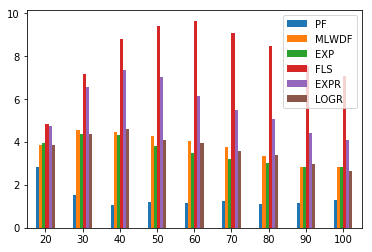

In [9]:
dfGPUTVIDEO = pd.DataFrame({'PF': MEGAVIDEO[1], 'MLWDF': MEGAVIDEO[2], 'EXP': MEGAVIDEO[3],
                       'FLS': MEGAVIDEO[4], 'EXPR': MEGAVIDEO[5], 'LOGR': MEGAVIDEO[6]},
                      index=[20,30,40,50,60,70,80,90,100])
plot = dfGPUTVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTVideo.pdf", bbox_inches='tight')

In [10]:
dfGPUTVIDEO

,PF,MLWDF,EXP,FLS,EXPR,LOGR
20,2.819613,3.879069,3.974747,4.858780,4.765389,3.877749
30,1.519591,4.560423,4.382265,7.158710,6.592070,4.381447
40,1.047619,4.461217,4.312328,8.831927,7.344764,4.615037
50,1.194533,4.291248,3.837561,9.405493,7.025937,4.077805
60,1.146782,4.033379,3.485397,9.661802,6.164172,3.949387
70,1.247198,3.765283,3.220224,9.067041,5.503388,3.568668
80,1.124231,3.340737,3.010023,8.471028,5.066645,3.405612
90,1.150787,2.849359,2.819643,7.559301,4.416031,2.991938
100,1.279937,2.823774,2.859403,7.065870,4.089470,2.671394


# Delay Jitter

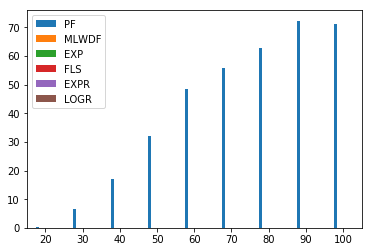

In [11]:
dfDELAYVIDEO = pd.DataFrame({'PF': DELAYVIDEO[1], 'MLWDF': DELAYVIDEO[2], 'EXP': DELAYVIDEO[3],
                            'FLS': DELAYVIDEO[4], 'EXPR': DELAYVIDEO[5], 'LOGR': DELAYVIDEO[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVideoPF.pdf", bbox_inches='tight')

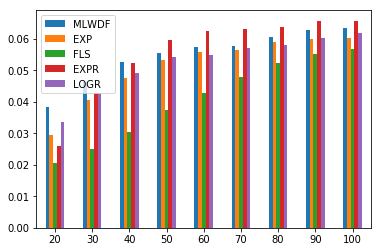

In [12]:
dfDELAYVIDEO = pd.DataFrame({'MLWDF': DELAYVIDEO[2], 'EXP': DELAYVIDEO[3],
                            'FLS': DELAYVIDEO[4], 'EXPR': DELAYVIDEO[5], 'LOGR': DELAYVIDEO[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVideo.pdf", bbox_inches='tight')

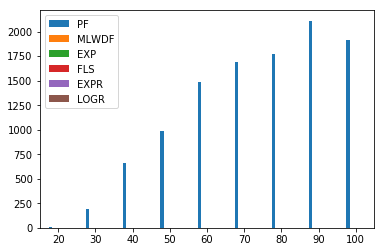

In [13]:
dfJITTERVIDEO = pd.DataFrame({'PF': JITTERVIDEO[1], 'MLWDF': JITTERVIDEO[2], 'EXP': JITTERVIDEO[3],
                            'FLS': JITTERVIDEO[4], 'EXPR': JITTERVIDEO[5], 'LOGR': JITTERVIDEO[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVideoPF.pdf", bbox_inches='tight')

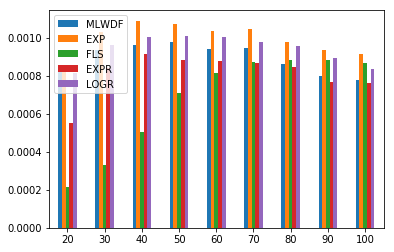

In [14]:
dfJITTERVIDEO = pd.DataFrame({'MLWDF': JITTERVIDEO[2], 'EXP': JITTERVIDEO[3],
                            'FLS': JITTERVIDEO[4], 'EXPR': JITTERVIDEO[5], 'LOGR': JITTERVIDEO[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVideo.pdf", bbox_inches='tight')

# VIDEO FAIRNESS

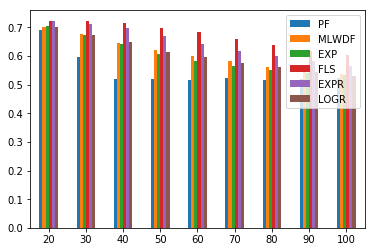

In [15]:
dfFAIRVIDEO = pd.DataFrame({'PF': FAIRVIDEO[1], 'MLWDF': FAIRVIDEO[2], 'EXP': FAIRVIDEO[3],
                            'FLS': FAIRVIDEO[4], 'EXPR': FAIRVIDEO[5], 'LOGR': FAIRVIDEO[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfFAIRVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/FairnessVideo.pdf", bbox_inches='tight')

In [16]:
dfFAIRVIDEO

,PF,MLWDF,EXP,FLS,EXPR,LOGR
20,0.692351,0.701294,0.703106,0.723149,0.721161,0.701116
30,0.596318,0.677704,0.672789,0.721318,0.713325,0.673424
40,0.519932,0.646864,0.641459,0.713644,0.696067,0.648452
50,0.518844,0.620790,0.608045,0.698077,0.670618,0.615126
60,0.516635,0.600519,0.583083,0.681994,0.642097,0.594952
70,0.521712,0.582137,0.564842,0.660306,0.617762,0.576500
80,0.515689,0.562002,0.551071,0.639331,0.599213,0.561144
90,0.519860,0.543403,0.538916,0.618623,0.581384,0.542674
100,0.522817,0.536025,0.534845,0.603893,0.566426,0.530259


# VIDEO PLR

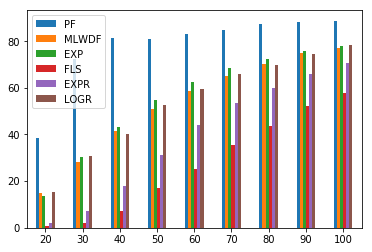

In [17]:
dfPLRVIDEO = pd.DataFrame({'PF': PLRVIDEO[1], 'MLWDF': PLRVIDEO[2], 'EXP': PLRVIDEO[3],
                            'FLS': PLRVIDEO[4], 'EXPR': PLRVIDEO[5], 'LOGR': PLRVIDEO[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfPLRVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossVideo.pdf", bbox_inches='tight')

# VOIP GPUT MB/s

In [18]:
MEGAVOIP = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVOICE:
    MEGAVOIP[sched] = np.true_divide(GPUTSVOICE[sched], 8)
MEGAVOIP

{1: array([0.15258113, 0.22733824, 0.30227968, 0.36957183, 0.45309696,
        0.53431296, 0.6138624 , 0.66985214, 0.7405312 ], dtype=float32),
 2: array([0.15545088, 0.21860352, 0.30423808, 0.37755647, 0.46146816,
        0.52180994, 0.6159258 , 0.6776499 , 0.7357952 ], dtype=float32),
 3: array([0.15730432, 0.22601728, 0.29678848, 0.3862221 , 0.45541632,
        0.5180134 , 0.59363586, 0.6831846 , 0.73119485], dtype=float32),
 4: array([0.15123712, 0.22996736, 0.29602304, 0.37589505, 0.45755392,
        0.53708035, 0.5975142 , 0.68718594, 0.7562573 ], dtype=float32),
 5: array([0.15371776, 0.21533953, 0.3013888 , 0.38133505, 0.454976  ,
        0.53562367, 0.6012339 , 0.6840115 , 0.7392051 ], dtype=float32),
 6: array([0.15180545, 0.22458369, 0.3046323 , 0.37265408, 0.4552704 ,
        0.53167105, 0.6027187 , 0.6666624 , 0.7368832 ], dtype=float32)}

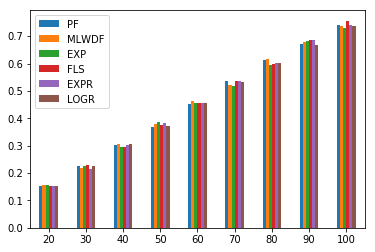

In [19]:
dfGPUTVOICE = pd.DataFrame({'PF': MEGAVOIP[1], 'MLWDF': MEGAVOIP[2], 'EXP': MEGAVOIP[3],
                       'FLS': MEGAVOIP[4], 'EXPR': MEGAVOIP[5], 'LOGR': MEGAVOIP[6]},
                      index=[20,30,40,50,60,70,80,90,100])
plot = dfGPUTVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTVoIP.pdf", bbox_inches='tight')

In [20]:
dfGPUTVOICE

,PF,MLWDF,EXP,FLS,EXPR,LOGR
20,0.152581,0.155451,0.157304,0.151237,0.153718,0.151805
30,0.227338,0.218604,0.226017,0.229967,0.215340,0.224584
40,0.302280,0.304238,0.296788,0.296023,0.301389,0.304632
50,0.369572,0.377556,0.386222,0.375895,0.381335,0.372654
60,0.453097,0.461468,0.455416,0.457554,0.454976,0.455270
70,0.534313,0.521810,0.518013,0.537080,0.535624,0.531671
80,0.613862,0.615926,0.593636,0.597514,0.601234,0.602719
90,0.669852,0.677650,0.683185,0.687186,0.684012,0.666662
100,0.740531,0.735795,0.731195,0.756257,0.739205,0.736883


# Delay Jitter

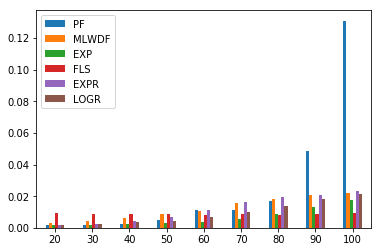

In [21]:
dfDELAYVOICE = pd.DataFrame({'PF': DELAYVOICE[1], 'MLWDF': DELAYVOICE[2], 'EXP': DELAYVOICE[3],
                            'FLS': DELAYVOICE[4], 'EXPR': DELAYVOICE[5], 'LOGR': DELAYVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVoIPPF.pdf", bbox_inches='tight')

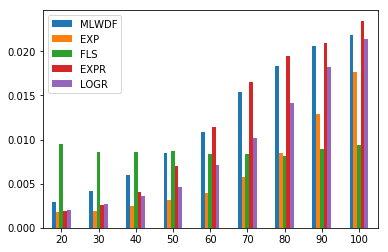

In [22]:
dfDELAYVOICE = pd.DataFrame({'MLWDF': DELAYVOICE[2], 'EXP': DELAYVOICE[3],
                            'FLS': DELAYVOICE[4], 'EXPR': DELAYVOICE[5], 'LOGR': DELAYVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVoIP.pdf", bbox_inches='tight')

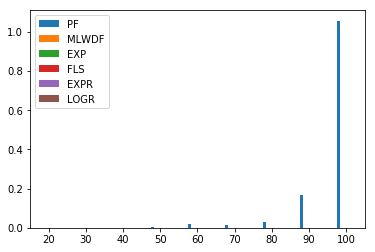

In [23]:
dfJITTERVOICE = pd.DataFrame({'PF': JITTERVOICE[1], 'MLWDF': JITTERVOICE[2], 'EXP': JITTERVOICE[3],
                            'FLS': JITTERVOICE[4], 'EXPR': JITTERVOICE[5], 'LOGR': JITTERVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVoIPPF.pdf", bbox_inches='tight')

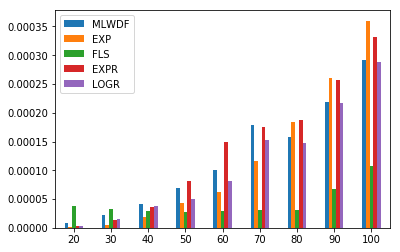

In [24]:
dfJITTERVOICE = pd.DataFrame({'MLWDF': JITTERVOICE[2], 'EXP': JITTERVOICE[3],
                            'FLS': JITTERVOICE[4], 'EXPR': JITTERVOICE[5], 'LOGR': JITTERVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVoIP.pdf", bbox_inches='tight')

# VOICE PLR

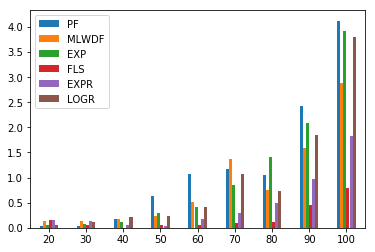

In [25]:
dfPLRVOICE = pd.DataFrame({'PF': PLRVOICE[1], 'MLWDF': PLRVOICE[2], 'EXP': PLRVOICE[3],
                            'FLS': PLRVOICE[4], 'EXPR': PLRVOICE[5], 'LOGR': PLRVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfPLRVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossVoice.pdf", bbox_inches='tight')

# INF BUF

In [29]:
MEGAINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSINFBUF:
    MEGAINFBUF[sched] = np.true_divide(GPUTSINFBUF[sched], 8)
MEGAINFBUF

{1: array([24.140095, 21.180302, 18.456   , 18.821262, 16.556633, 15.305092,
        14.89354 , 14.992505, 15.131351], dtype=float32),
 2: array([23.867916, 22.03495 , 22.898756, 23.05053 , 23.666079, 22.808153,
        23.086542, 23.698017, 23.545263], dtype=float32),
 3: array([25.400599, 24.424034, 23.188313, 23.161566, 23.163134, 23.846024,
        23.546024, 22.384665, 23.69588 ], dtype=float32),
 4: array([19.287907, 19.335234, 17.235083, 16.437971, 16.056398, 15.700737,
        16.742714, 17.054913, 16.898336], dtype=float32),
 5: array([22.813395, 19.987665, 20.363455, 20.252604, 19.98666 , 20.82024 ,
        20.996271, 21.238369, 21.685698], dtype=float32),
 6: array([23.434546, 23.172855, 22.799608, 22.94832 , 24.006025, 24.078287,
        23.342392, 23.178751, 22.469576], dtype=float32)}

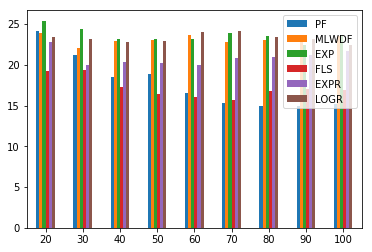

In [30]:
dfGPUTINFBUF = pd.DataFrame({'PF': MEGAINFBUF[1], 'MLWDF': MEGAINFBUF[2], 'EXP': MEGAINFBUF[3],
                       'FLS': MEGAINFBUF[4], 'EXPR': MEGAINFBUF[5], 'LOGR': MEGAINFBUF[6]},
                      index=[20,30,40,50,60,70,80,90,100])
plot = dfGPUTINFBUF.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTInfBuf.pdf", bbox_inches='tight')

In [31]:
dfGPUTINFBUF

,PF,MLWDF,EXP,FLS,EXPR,LOGR
20,24.140095,23.867916,25.400599,19.287907,22.813395,23.434546
30,21.180302,22.034950,24.424034,19.335234,19.987665,23.172855
40,18.455999,22.898756,23.188313,17.235083,20.363455,22.799608
50,18.821262,23.050529,23.161566,16.437971,20.252604,22.948320
60,16.556633,23.666079,23.163134,16.056398,19.986660,24.006025
70,15.305092,22.808153,23.846024,15.700737,20.820240,24.078287
80,14.893540,23.086542,23.546024,16.742714,20.996271,23.342392
90,14.992505,23.698017,22.384665,17.054913,21.238369,23.178751
100,15.131351,23.545263,23.695881,16.898336,21.685698,22.469576


# Delay Jitter

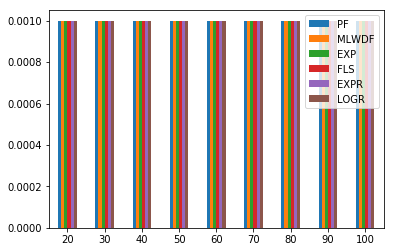

In [32]:
dfDELAYINFBUF = pd.DataFrame({'PF': DELAYINFBUF[1], 'MLWDF': DELAYINFBUF[2], 'EXP': DELAYINFBUF[3],
                            'FLS': DELAYINFBUF[4], 'EXPR': DELAYINFBUF[5], 'LOGR': DELAYINFBUF[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYINFBUF.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayINFBUFPF.pdf", bbox_inches='tight')

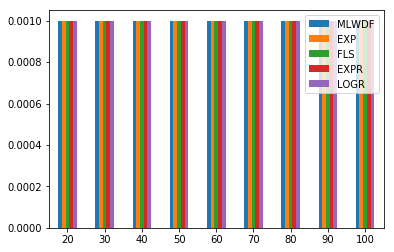

In [33]:
dfDELAYINFBUF = pd.DataFrame({'MLWDF': DELAYINFBUF[2], 'EXP': DELAYINFBUF[3],
                            'FLS': DELAYINFBUF[4], 'EXPR': DELAYINFBUF[5], 'LOGR': DELAYINFBUF[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYINFBUF.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayInfBuf.pdf", bbox_inches='tight')

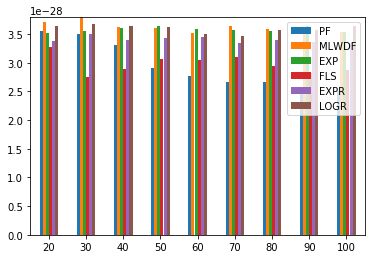

In [34]:
dfJITTERINFBUF = pd.DataFrame({'PF': JITTERINFBUF[1], 'MLWDF': JITTERINFBUF[2], 'EXP': JITTERINFBUF[3],
                            'FLS': JITTERINFBUF[4], 'EXPR': JITTERINFBUF[5], 'LOGR': JITTERINFBUF[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERINFBUF.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterInfBufPF.pdf", bbox_inches='tight')

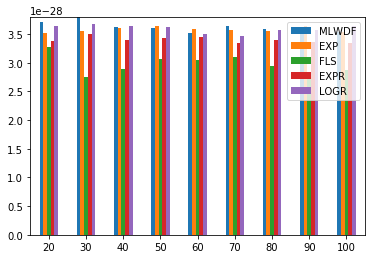

In [35]:
dfJITTERINFBUF = pd.DataFrame({'MLWDF': JITTERINFBUF[2], 'EXP': JITTERINFBUF[3],
                            'FLS': JITTERINFBUF[4], 'EXPR': JITTERINFBUF[5], 'LOGR': JITTERINFBUF[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERINFBUF.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterInfBuf.pdf", bbox_inches='tight')

# VOICE PLR

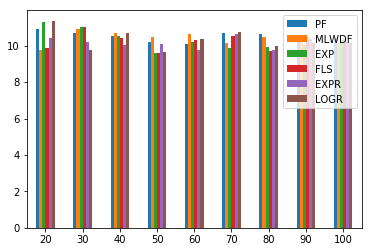

In [36]:
dfPLRINFBUF = pd.DataFrame({'PF': PLRINFBUF[1], 'MLWDF': PLRINFBUF[2], 'EXP': PLRINFBUF[3],
                            'FLS': PLRINFBUF[4], 'EXPR': PLRINFBUF[5], 'LOGR': PLRINFBUF[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfPLRINFBUF.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossInfBuf.pdf", bbox_inches='tight')

# Loss Ratio

In [26]:
averagePacketLoss = {}
for key in PACKETLOSS:
    averagePacketLoss[key] = []
    for i in range(0, 9):
        average = sum(PACKETLOSS[key][i])/len(PACKETLOSS[key][i])         
        averagePacketLoss[key].append(average)

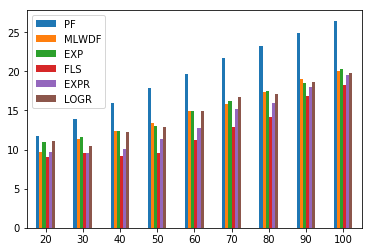

In [27]:
dfLossRatio = pd.DataFrame({'PF': averagePacketLoss[1], 'MLWDF': averagePacketLoss[2], 'EXP': averagePacketLoss[3],
                            'FLS': averagePacketLoss[4], 'EXPR': averagePacketLoss[5], 'LOGR': averagePacketLoss[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfLossRatio.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossRatio.pdf", bbox_inches='tight')

In [28]:
dfLossRatio

,PF,MLWDF,EXP,FLS,EXPR,LOGR
20,11.696552,9.657321,11.001947,9.048378,9.660849,11.160954
30,13.959570,11.395448,11.638498,9.537148,9.569852,10.500238
40,15.902214,12.369527,12.391129,9.241488,10.030218,12.255569
50,17.841066,13.421984,13.019650,9.543735,11.374303,12.910537
60,19.653223,14.996969,14.930842,11.171062,12.797309,14.913518
70,21.757280,15.816453,16.154774,12.936624,15.224308,16.740196
80,23.237684,17.376478,17.483644,14.201983,15.954392,17.066929
90,24.910725,18.976112,18.488905,16.810257,18.013855,18.669764
100,26.477448,20.055994,20.350304,18.276794,19.498676,19.831911


# 120 KM/H

In [ ]:
GPUTSVIDEO120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
FAIRVIDEO120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
DELAYVIDEO120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
JITTERVIDEO120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
GPUTSVOICE120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
FAIRVOICE120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
DELAYVOICE120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
JITTERVOICE120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
PACKETLOSS120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVIDEO:
    for ue in range(20, 101, 10):
        info = LTEParser.parse(files[sched][120][ue], 100)
        GPUTSVIDEO120[sched].append(info[0])
        FAIRVIDEO120[sched].append(info[1])
        DELAYVIDEO120[sched].append(info[2])
        JITTERVIDEO120[sched].append(info[3])
        GPUTSVOICE120[sched].append(info[4])
        FAIRVOICE120[sched].append(info[5])
        DELAYVOICE120[sched].append(info[6])
        JITTERVOICE120[sched].append(info[7])
        PACKETLOSS120[sched].append(info[8])
    GPUTSVIDEO120[sched] = np.array(GPUTSVIDEO120[sched], dtype=np.float32)
    FAIRVIDEO120[sched] = np.array(FAIRVIDEO120[sched], dtype=np.float32)
    DELAYVIDEO120[sched] = np.array(DELAYVIDEO120[sched], dtype = np.float32)
    JITTERVIDEO120[sched] = np.array(JITTERVIDEO120[sched], dtype = np.float32)
    GPUTSVOICE120[sched] = np.array(GPUTSVOICE120[sched], dtype=np.float32)
    FAIRVOICE120[sched] = np.array(FAIRVOICE120[sched], dtype=np.float32)
    DELAYVOICE120[sched] = np.array(DELAYVOICE120[sched], dtype = np.float32)
    JITTERVOICE120[sched] = np.array(JITTERVOICE120[sched], dtype = np.float32)
    PACKETLOSS120[sched] = np.array(PACKETLOSS120[sched], dtype=np.float32)

# VIDEO GPUT MB/s

In [ ]:
MEGAVIDEO120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVIDEO120:
    MEGAVIDEO120[sched] = np.true_divide(GPUTSVIDEO120[sched], 8)
MEGAVIDEO120

In [ ]:
dfGPUTVIDEO120 = pd.DataFrame({'PF': MEGAVIDEO120[1], 'MLWDF': MEGAVIDEO120[2], 'EXP': MEGAVIDEO120[3],
                       'FLS': MEGAVIDEO120[4], 'EXPR': MEGAVIDEO120[5], 'LOGR': MEGAVIDEO120[6]},
                      index=[20,30,40,50,60,70,80,90,100])
plot = dfGPUTVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTVideo120.pdf", bbox_inches='tight')

In [ ]:
dfGPUTVIDEO120

# Delay Jitter

In [ ]:
dfDELAYVIDEO120 = pd.DataFrame({'PF': DELAYVIDEO120[1], 'MLWDF': DELAYVIDEO120[2], 'EXP': DELAYVIDEO120[3],
                            'FLS': DELAYVIDEO120[4], 'EXPR': DELAYVIDEO120[5], 'LOGR': DELAYVIDEO120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVideoPF120.pdf", bbox_inches='tight')

In [ ]:
dfDELAYVIDEO120 = pd.DataFrame({'MLWDF': DELAYVIDEO120[2], 'EXP': DELAYVIDEO120[3],
                            'FLS': DELAYVIDEO120[4], 'EXPR': DELAYVIDEO120[5], 'LOGR': DELAYVIDEO120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVideo120.pdf", bbox_inches='tight')

In [ ]:
dfJITTERVIDEO120 = pd.DataFrame({'PF': JITTERVIDEO120[1], 'MLWDF': JITTERVIDEO120[2], 'EXP': JITTERVIDEO120[3],
                            'FLS': JITTERVIDEO120[4], 'EXPR': JITTERVIDEO120[5], 'LOGR': JITTERVIDEO120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVideoPF120.pdf", bbox_inches='tight')

In [ ]:
dfJITTERVIDEO120 = pd.DataFrame({'MLWDF': JITTERVIDEO120[2], 'EXP': JITTERVIDEO120[3],
                            'FLS': JITTERVIDEO120[4], 'EXPR': JITTERVIDEO120[5], 'LOGR': JITTERVIDEO120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVideo120.pdf", bbox_inches='tight')

# VIDEO FAIRNESS

In [ ]:
dfFAIRVIDEO120 = pd.DataFrame({'PF': FAIRVIDEO120[1], 'MLWDF': FAIRVIDEO120[2], 'EXP': FAIRVIDEO120[3],
                            'FLS': FAIRVIDEO120[4], 'EXPR': FAIRVIDEO120[5], 'LOGR': FAIRVIDEO120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfFAIRVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/FairnessVideo120.pdf", bbox_inches='tight')

In [ ]:
dfFAIRVIDEO120

# VOIP GPUT MB/s

In [ ]:
MEGAVOIP120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVOICE120:
    MEGAVOIP120[sched] = np.true_divide(GPUTSVOICE120[sched], 8)
MEGAVOIP120

In [ ]:
dfGPUTVOICE120 = pd.DataFrame({'PF': MEGAVOIP120[1], 'MLWDF': MEGAVOIP120[2], 'EXP': MEGAVOIP120[3],
                       'FLS': MEGAVOIP120[4], 'EXPR': MEGAVOIP120[5], 'LOGR': MEGAVOIP120[6]},
                      index=[20,30,40,50,60,70,80,90,100])
plot = dfGPUTVOICE120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTVoIP120.pdf", bbox_inches='tight')

In [ ]:
dfGPUTVOICE120

# Delay Jitter

In [ ]:
dfDELAYVOICE120 = pd.DataFrame({'PF': DELAYVOICE120[1], 'MLWDF': DELAYVOICE120[2], 'EXP': DELAYVOICE120[3],
                            'FLS': DELAYVOICE120[4], 'EXPR': DELAYVOICE120[5], 'LOGR': DELAYVOICE120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVOICE120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVoIPPF120.pdf", bbox_inches='tight')

In [ ]:
dfDELAYVOICE120 = pd.DataFrame({'MLWDF': DELAYVOICE120[2], 'EXP': DELAYVOICE120[3],
                            'FLS': DELAYVOICE120[4], 'EXPR': DELAYVOICE120[5], 'LOGR': DELAYVOICE120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVOICE120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVoIP120.pdf", bbox_inches='tight')

In [ ]:
dfJITTERVOICE120 = pd.DataFrame({'PF': JITTERVOICE120[1], 'MLWDF': JITTERVOICE120[2], 'EXP': JITTERVOICE120[3],
                            'FLS': JITTERVOICE120[4], 'EXPR': JITTERVOICE120[5], 'LOGR': JITTERVOICE120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVOICE120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVoIPPF120.pdf", bbox_inches='tight')

In [ ]:
dfJITTERVOICE120 = pd.DataFrame({'MLWDF': JITTERVOICE120[2], 'EXP': JITTERVOICE120[3],
                            'FLS': JITTERVOICE120[4], 'EXPR': JITTERVOICE120[5], 'LOGR': JITTERVOICE120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVOICE120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVoIP120.pdf", bbox_inches='tight')

# Loss Ratio

In [ ]:
averagePacketLoss120 = {}
for key in PACKETLOSS120:
    averagePacketLoss120[key] = []
    for i in range(0, 9):
        average = sum(PACKETLOSS120[key][i])/len(PACKETLOSS120[key][i])         
        averagePacketLoss120[key].append(average)

In [ ]:
dfLossRatio120 = pd.DataFrame({'PF': averagePacketLoss120[1], 'MLWDF': averagePacketLoss120[2], 'EXP': averagePacketLoss120[3],
                            'FLS': averagePacketLoss120[4], 'EXPR': averagePacketLoss120[5], 'LOGR': averagePacketLoss120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfLossRatio120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossRatio120.pdf", bbox_inches='tight')

In [ ]:
dfLossRatio120